<a href="https://colab.research.google.com/github/Hamid-Mofidi/Diffusion-Models/blob/main/GMM_noising/DM_Forward_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib
from sklearn.datasets import fetch_openml
import torchvision
from torchvision import transforms

In [2]:
# Parameters for generating Gaussian distributions
n_clusters = 6

In [3]:
#CIFAR-10 dataset: Each image is a 32x32 pixel image and there are 60,000 such images.
# Thus, shape of X is (60000, 32x32), where 32x32 is the flattened size of each image (32 * 32)

def CIFAR10_dataset(random_seed=42):
    # Set NumPy random seed
    np.random.seed(random_seed)

    # Load CIFAR-10 dataset
    # Define a transform to normalize the data
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Download the CIFAR-10 training set
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    # Extract features and labels
    X_cifar10, y_cifar10 = trainset.data, trainset.targets

    # Convert X_cifar10 and y_cifar10 to NumPy arrays
    X_cifar10_np = np.array(X_cifar10)
    y_cifar10_np = np.array(y_cifar10)

    # Print the shapes
    print("X_cifar10 shape:", X_cifar10_np.shape)
    print("y_cifar10 shape:", y_cifar10_np.shape)

    # Select a subset of the data (e.g., first 10,000 samples)
    subset_size = n_clusters
    a_subset, b_subset = X_cifar10_np[:subset_size], y_cifar10_np[:subset_size]

    return a_subset, b_subset

In [4]:
# Load CIFAR-10 data
a_subset, b_subset = CIFAR10_dataset(random_seed=42)

Files already downloaded and verified
X_cifar10 shape: (50000, 32, 32, 3)
y_cifar10 shape: (50000,)


In [5]:
print(a_subset.shape)
print(b_subset.shape)
print(a_subset[0].shape)

(6, 32, 32, 3)
(6,)
(32, 32, 3)


In [6]:
# Create an array X of size n_clusters x 784 x 1
X = np.zeros((n_clusters, 32 * 32 * 3, 1))

# Reshape and store elements from a_subset in X
for i in range(n_clusters):
    X[i] = a_subset[i].reshape(-1, 1)/ 255.0  # Normalize by dividing by 255.0

print(X.shape)
print(X[0].shape)
print('first image is =', b_subset[0])
print('Second image is =',b_subset[1])


(6, 3072, 1)
(3072, 1)
first image is = 6
Second image is = 9


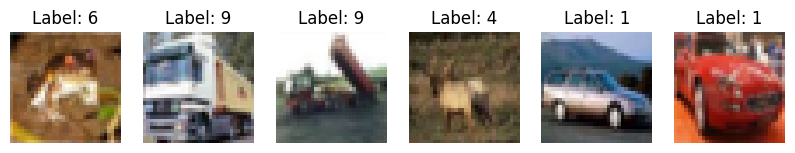

In [7]:
# Create a figure with multiple subplots
fig, axs = plt.subplots(1, n_clusters, figsize=(10, 3))


# Reshape and plot each image horizontally
for i in range(n_clusters):
    image_to_plot = X[i].reshape(32, 32, 3)
    axs[i].imshow(image_to_plot, cmap='gray')
    axs[i].set_title(f"Label: {b_subset[i]}")
    axs[i].axis('off')

plt.show()

In [8]:
def plot_noisy_images(X_noised_diff_step, n_clusters):
    fig, axes = plt.subplots(n_clusters, 2, figsize=(8, 2 * n_clusters))

    for i in range(n_clusters):
      # Plot original image
      axes[i, 0].imshow(X[i].reshape(32, 32, 3))

      # Plot noised image
      axes[i, 1].imshow(X_noised_diff_step[i].reshape(32, 32, 3))

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [9]:
def plot_CIFAR10_histograms(Y, n_clusters):
    fig, ax = plt.subplots(figsize=(6, 4))

    for i in range(n_clusters):
        ax.hist(Y[i].flatten(), bins=50, alpha=0.5, label=f'Cluster {i}')

    ax.set_title('Histograms of Different Clusters')
    ax.set_xlabel('Feature Value (Normalized)')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

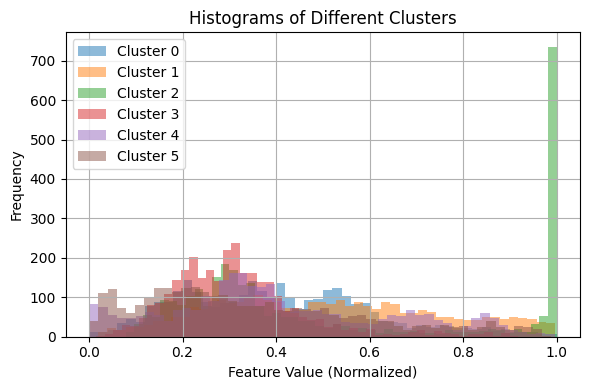

In [10]:
# Plot histograms for each cluster in X
plot_CIFAR10_histograms(X, n_clusters)

In [11]:
# bet = np.linspace(.0001, .02, 1000)
# alf = 1 - bet
# alf_cumprod = np.cumprod(alf)

# print(alf[-1])
# print(alf_cumprod[-1])

# print(alf_cumprod.shape)
# noise_X = np.random.randn(1)
# print(noise_X)

# random_numbers = np.random.randn(5)

# print(random_numbers)

0.98
4.035829765375676e-05
(1000,)
[0.49671415]
[-0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696]


In [12]:
class DiffusionProbabilisticModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, diffusion_steps=100):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.diffusion_steps = diffusion_steps

        self.betas = np.linspace(start_schedule, end_schedule, diffusion_steps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = np.cumprod(self.alphas)

    def forward(self, U):
        noise = np.random.randn(*U.shape)
        sqrt_alphas_cumprod_t = np.sqrt(self.alphas_cumprod)
        sqrt_one_minus_alphas_cumprod_t = np.sqrt(1. - self.alphas_cumprod)

        mean = sqrt_alphas_cumprod_t * U
        variance = sqrt_one_minus_alphas_cumprod_t * noise
        X_noised = mean + variance

        return X_noised


In [13]:
model = DiffusionProbabilisticModel()

In [14]:
#X_noised = X.copy()
X_noised = model.forward(X)

In [15]:
#  print(X_noised.shape)
#  X_noised[:, :, 1].shape

In [16]:
# Preparation for plotting noisy images
diffusion_steps=100
X_noised_reshaped = np.zeros((diffusion_steps,n_clusters, 3072, 1))

for i in range (diffusion_steps):
  X_noised_reshaped[i] = np.expand_dims(X_noised[:, :, i], axis=-1)

X_noised_reshaped.shape

(100, 6, 3072, 1)

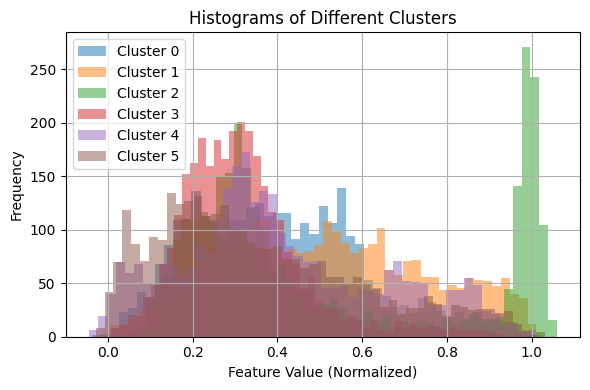

In [17]:
diff_step = int((1/100) * diffusion_steps)  # %1 of diffusion_steps

# Plot histograms for each cluster in X_noised
plot_CIFAR10_histograms(X_noised[:, :, diff_step], n_clusters)


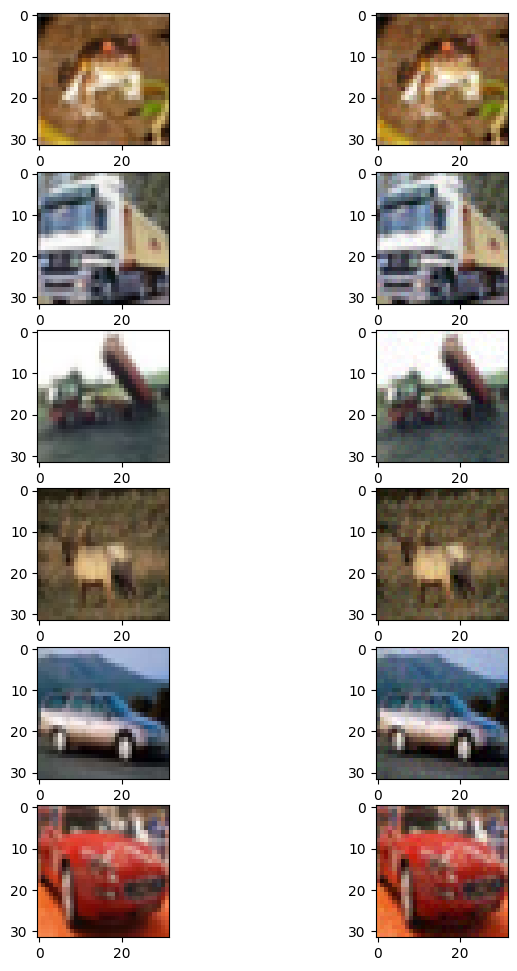

In [18]:
diff_step = int((1/100) * diffusion_steps)  # %1 of diffusion_steps
# Plot noisy images for each cluster
#X_noised_diff_step = X_noised_reshaped[diff_step]
X_noised_diff_step = X_noised_reshaped[diff_step, :, :, :]

#print(X_noised_diff_step.shape)
plot_noisy_images(X_noised_diff_step, n_clusters)


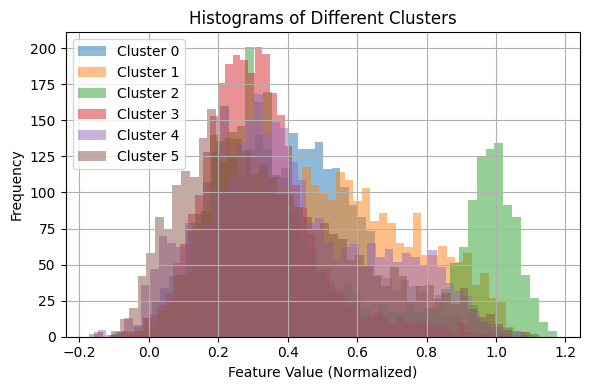

In [19]:
diff_step = int((5/100) * diffusion_steps)  # %5 of diffusion_steps

# Plot histograms for each cluster in X_noised
plot_CIFAR10_histograms(X_noised[:, :, diff_step ], n_clusters)

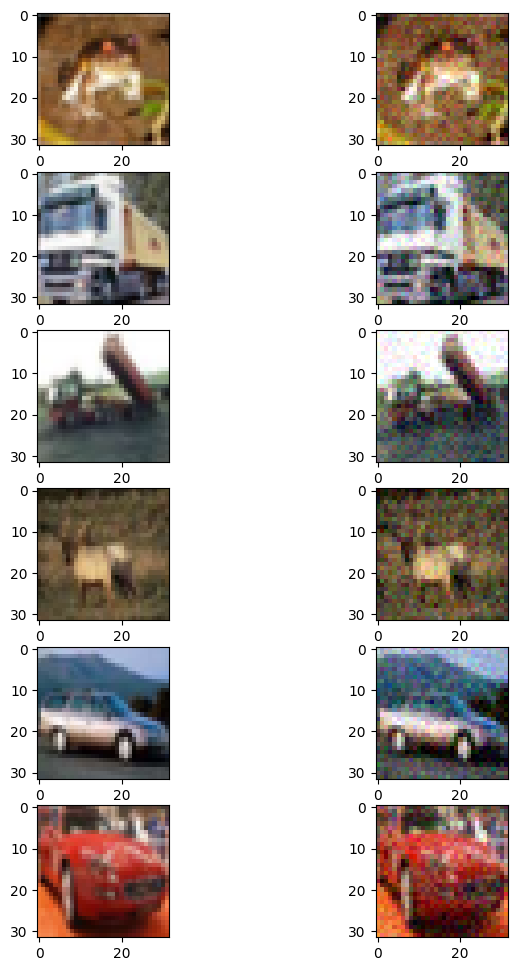

In [20]:
diff_step = int((5/100) * diffusion_steps)  # %5 of diffusion_steps

# Plot noisy images for each cluster
X_noised_diff_step = X_noised_reshaped[diff_step]
#print(X_noised_diff_step.shape)

plot_noisy_images(X_noised_diff_step, n_clusters)

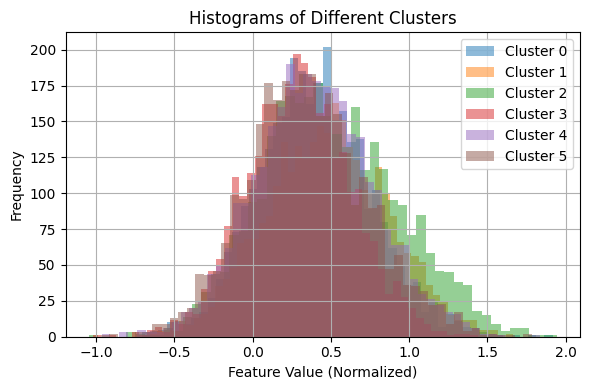

In [21]:
diff_step = int((30/100) * diffusion_steps)  # %30 of diffusion_steps

# Plot histograms for each cluster in X_noised
plot_CIFAR10_histograms(X_noised[:, :, diff_step ], n_clusters)

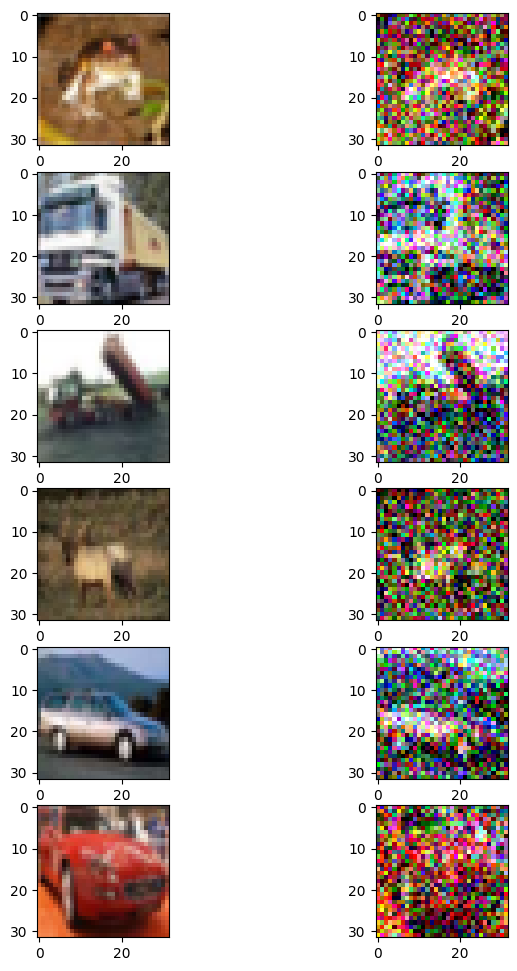

In [22]:
diff_step = int((30/100) * diffusion_steps)  # %30 of diffusion_steps

# Plot noisy images for each cluster
X_noised_diff_step = X_noised_reshaped[diff_step]
#print(X_noised_diff_step.shape)

plot_noisy_images(X_noised_diff_step, n_clusters)

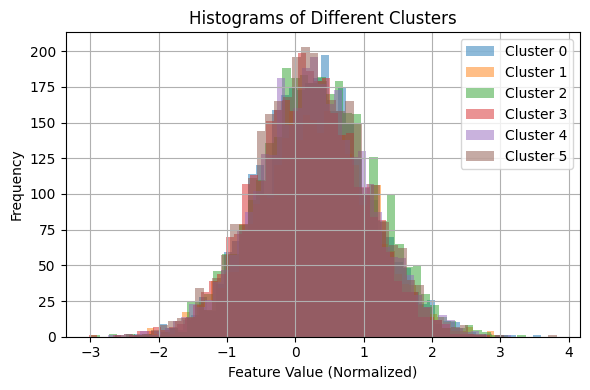

In [23]:
diff_step = int((99.9/100) * diffusion_steps)  # %99.9 of diffusion_steps

# Plot histograms for each cluster in X_noised
plot_CIFAR10_histograms(X_noised[:, :, diff_step ], n_clusters)

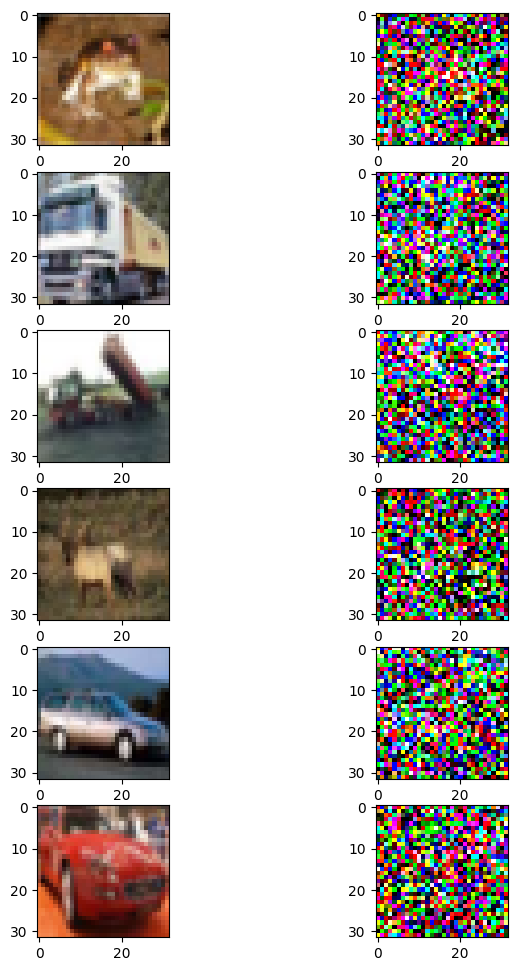

In [24]:
diff_step = int((99.9/100) * diffusion_steps)  # %99.9 of diffusion_steps

# Plot noisy images for each cluster
X_noised_diff_step = X_noised_reshaped[diff_step]
#print(X_noised_diff_step.shape)

plot_noisy_images(X_noised_diff_step, n_clusters)